In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Data

Mounted at /content/drive
/content/drive/MyDrive/Data


In [ ]:
%cd /content


/content


In [ ]:
!pip install -q -U tensorflow-text
!pip install -q tf-models-official

     |████████████████████████████████| 4.9 MB 8.1 MB/s 
     |████████████████████████████████| 1.8 MB 8.6 MB/s 
     |████████████████████████████████| 47.6 MB 1.2 MB/s 
     |████████████████████████████████| 213 kB 88.7 MB/s 
     |████████████████████████████████| 596 kB 65.1 MB/s 
     |████████████████████████████████| 99 kB 11.2 MB/s 
     |████████████████████████████████| 352 kB 67.3 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 1.1 MB 60.3 MB/s 
     |████████████████████████████████| 90 kB 12.5 MB/s 
     |████████████████████████████████| 1.2 MB 87.0 MB/s 


build dataset in local

In [ ]:
import os
classes = ["fake", "satire", "bias", "conspiracy", "junksci", "hate", "clickbait", "unreliable", "political", "reliable"]
os.mkdir('dataset')
os.mkdir('dataset/train')
os.mkdir('dataset/test')
for cl in classes:
    os.mkdir(os.path.join("dataset/train", cl))
    os.mkdir(os.path.join("dataset/test", cl))

In [ ]:
%ls

dataset/  drive/  sample_data/


In [ ]:
rm -r dataset

In [ ]:
def get_types(web_df, source_url):

  source = source_url.lower()
  source = source.replace('www\.', '')
  row = web_df.loc[web_df['url'] == source]

  if row.size > 0:
    # print("HERE", [row.iloc[0]['type'], row.iloc[0]['2nd_type'], row.iloc[0]['3rd_type']])
    return row.iloc[0]['type'], row.iloc[0]['2nd_type'], row.iloc[0]['3rd_type']
  else:
    return None, None, None

In [ ]:
import os
import shutil

import tensorflow as tf
from tensorflow.keras import losses
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt


Create dataset from directory

In [ ]:
import pandas as pd
import os
import random

train_target = 40000 # number of articles per class
test_target =10000

def put_in_folder(type_, content, article_id, subdir):
    # print(1)
    f = open(f"dataset/{subdir}/{type_}/{article_id}.txt", 'w')
    f.write(content)
    f.close()

# classes = ["fake", "satire", "bias", "conspiracy", "state", "junksci", "hate", "clickbait", "unreliable", "political", "reliable"]
classes = ["fake", "satire", "bias",  "conspiracy", "junksci", "hate", "clickbait", "unreliable", "political", "reliable"]


# split = int(.8 * len(df))
# df_train = fd.iloc[:split]
# df_test = fd.iloc[split:]

train_counts = [0,0,0,0,0,0,0,0,0,0]
test_counts = [0,0,0,0,0,0,0,0,0,0]
path = 'drive/My Drive/Data/fullcontextnews_chunked'
file_list = os.listdir(path)
print(file_list)
file_list.remove('news_006.csv')
file_list.remove('news_032.csv')
file_list.remove('news_034.csv')
file_list.remove('news_028.csv')
file_list.remove('news_029.csv')
file_list.remove('news_027.csv')
random.shuffle(file_list)

print(file_list)
files = iter(file_list)

p = os.path.join(path,next(files))
print(p)
df = pd.read_csv(p)
row_num = 1
train_done = all(counts >= train_target for counts in train_counts)
test_done = all(counts >= test_target for counts in test_counts)
# for index, row in fd.iterrows():

# for making teh types
web_df = pd.read_csv('websites.csv')
# print(web_df.head())
row_iterator = df.iterrows()
while (not train_done or not test_done):
    
    
    try:
      row = next(row_iterator)[1]
    except StopIteration:
      try:
        next_file = next(files)
      except StopIteration:
        print("something happened that was bad")
        break
      p = os.path.join(path,next_file)
      df = pd.read_csv(p)
      row_iterator = df.iterrows()
      row = next(row_iterator)[1]
      print(row)
      
    #make change because types were not in this full context chunked csv data file
    url = row['domain']
    t1, t2, t3 = get_types(web_df, url)

    if t1 in classes:
        i = classes.index(t1)
        if train_counts[i] < train_target:
            train_counts[i] += 1

            put_in_folder(t1, row['content'], row_num, 'train')
        elif test_counts[i] < test_target:
            test_counts[i]+=1
            put_in_folder(t1, row['content'], row_num, 'test')
    else:
        print(p)
    #   print("t1: ", t1)
    if t2 in classes:
        i = classes.index(t2)
        if train_counts[i] < train_target:
            train_counts[i] += 1
            put_in_folder(t2, row['content'], row_num, 'train')
        elif test_counts[i] < test_target:
            test_counts[i]+=1
            put_in_folder(t2, row['content'], row_num, 'test')
    # else:
    #   print("t2: ", t2)
    if t3 in classes:
        i = classes.index(t3)
        if train_counts[i] < train_target:
            train_counts[i] += 1
            put_in_folder(t3, row['content'], row_num, 'train')
        elif test_counts[i] < test_target:
            test_counts[i]+=1
            put_in_folder(t3, row['content'], row_num, 'test')
    # else:
    #   print("t3: ", t3)
    row_num += 1
    print("train ", train_counts, "  test ", test_counts)
    train_done = all(counts >= train_target for counts in train_counts)
    test_done = all(counts >= test_target for counts in test_counts)
    

Streaming output truncated to the last 5000 lines.
drive/My Drive/Data/fullcontextnews_chunked/news_035.csv
train  [40000, 40000, 40000, 40000, 40000, 40000, 40000, 40000, 40000, 32499]   test  [10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 0]
drive/My Drive/Data/fullcontextnews_chunked/news_035.csv
train  [40000, 40000, 40000, 40000, 40000, 40000, 40000, 40000, 40000, 32499]   test  [10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 0]
drive/My Drive/Data/fullcontextnews_chunked/news_035.csv
train  [40000, 40000, 40000, 40000, 40000, 40000, 40000, 40000, 40000, 32499]   test  [10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 0]
drive/My Drive/Data/fullcontextnews_chunked/news_035.csv
train  [40000, 40000, 40000, 40000, 40000, 40000, 40000, 40000, 40000, 32499]   test  [10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 0]
drive/My Drive/Data/fullcontextnews_chunked/news_035.csv
train  [40000, 40000, 40000, 40000, 40000, 40000, 40

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Streaming output truncated to the last 5000 lines.
train  [40000, 40000, 40000, 40000, 40000, 40000, 40000, 40000, 40000, 40000]   test  [10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 9785]
train  [40000, 40000, 40000, 40000, 40000, 40000, 40000, 40000, 40000, 40000]   test  [10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 9785]
train  [40000, 40000, 40000, 40000, 40000, 40000, 40000, 40000, 40000, 40000]   test  [10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 9785]
train  [40000, 40000, 40000, 40000, 40000, 40000, 40000, 40000, 40000, 40000]   test  [10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 9785]
train  [40000, 40000, 40000, 40000, 40000, 40000, 40000, 40000, 40000, 40000]   test  [10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 9785]
train  [40000, 40000, 40000, 40000, 40000, 40000, 40000, 40000, 40000, 40000]   test  [10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 9785]
train  [40000

In [ ]:
tf.get_logger().setLevel('ERROR')

AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'dataset/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'dataset/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'dataset/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("article", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])
print("Label 3 corresponds to", raw_train_ds.class_names[3])
print("Label 4 corresponds to", raw_train_ds.class_names[4])
print("Label 5 corresponds to", raw_train_ds.class_names[5])
print("Label 6 corresponds to", raw_train_ds.class_names[6])
print("Label 7 corresponds to", raw_train_ds.class_names[7])
print("Label 8 corresponds to", raw_train_ds.class_names[8])
print("Label 9 corresponds to", raw_train_ds.class_names[9])
# print("Label 10 corresponds to", raw_train_ds.class_names[10])



Found 400000 files belonging to 10 classes.
Using 320000 files for training.
Found 400000 files belonging to 10 classes.
Using 80000 files for validation.
Found 100000 files belonging to 10 classes.
article b'Advertisements Advertisements #Roger Goodell, according to a 2012 New York Times article, made a cool $$44 million that year and has averaged nearly $$25 million over his tenure as #NFL commissioner. Now I think Roger is a nice guy, and, I don\xe2\x80\x99t disagree with his decisions on fines and suspensions exacted on NFL players [VIDEO]over the last several years. However, $$25MM, are you kidding me; that\xe2\x80\x99s a lot of money. Roger Goodell is making more money than most realize The NFL has grown into an over $$10 billion business since the AFL-NFL merger in the late 1960\xe2\x80\x99s. There have been lots of feel-good stories during the growth of the NFL. However, the league has reached a point where maintenance, not growth, presents the biggest challenge for the #Nation

Create bert modle

In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')


bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)


BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


Print outputs to test

In [ ]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

bert_model = hub.KerasLayer(tfhub_handle_encoder)

bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')


Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]
Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262885  0.99280983 -0.18611856  0.36673826  0.15233693  0.65504473
  0.9681154  -0.94862705  0.0021619  -0.9877732   0.06842698 -0.9763061 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946355  0.34321284  0.3323149  ...  0.21300808  0.71020824
  -0.05771172]
 [-0.2874203   0.31981018 -0.2301853  ...  0.58455014 -0.21329692
   0.7269214 ]
 [-0.66157     0.6887689  -0.8743298  ...  0.10877271 -0.26173168
   0.47855347]
 ...
 [-0.22561166 -0.28925633 -0.07064366 ...  0.47566074  0.83277154
   0.4002533 ]
 [-0.29824263 -0.2747314  -0.05450518 ...  0.48849723  1.095536
   0.18163356]
 [-0.443

Create classifier builder method

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(10, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)


tf.Tensor(
[[0.61792296 0.5096088  0.3473614  0.60835516 0.58310246 0.13156366
  0.30648592 0.26527435 0.4210867  0.72083217]], shape=(1, 10), dtype=float32)


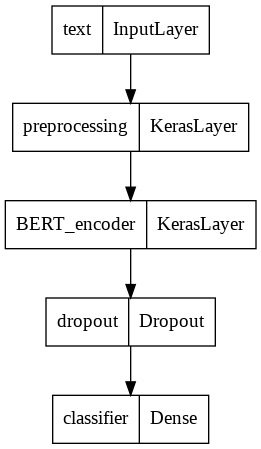

In [ ]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.keras.utils.plot_model(classifier_model)

Loss and optimizer. Just guessing here

In [ ]:
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.metrics.CategoricalAccuracy()

In [ ]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/10
10000/10000 [==============================] - 1687s 168ms/step - loss: 1.4073 - categorical_accuracy: 0.0960 - val_loss: 1.0054 - val_categorical_accuracy: 0.0616
Epoch 2/10
10000/10000 [==============================] - 1646s 165ms/step - loss: 0.9468 - categorical_accuracy: 0.0969 - val_loss: 0.8826 - val_categorical_accuracy: 0.0885
Epoch 3/10
10000/10000 [==============================] - 1624s 162ms/step - loss: 0.7990 - categorical_accuracy: 0.0985 - val_loss: 0.8575 - val_categorical_accuracy: 0.1155
Epoch 4/10
10000/10000 [==============================] - 1617s 162ms/step - loss: 0.7033 - categorical_accuracy: 0.0993 - val_loss: 0.8630 - val_categorical_accuracy: 0.1148
Epoch 5/10
10000/10000 [==============================] - 1619s 162ms/step - loss: 0.6310 - categorical_accuracy: 0.1013 - val_loss: 0.8868 - val_categorical_accuracy: 0.1075
Epoch 6/10
10000/10000 [=========

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

3125/3125 [==============================] - 247s 79ms/step - loss: 1.9553 - categorical_accuracy: 0.0750
Loss: 1.9552879333496094
Accuracy: 0.07496999949216843


dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


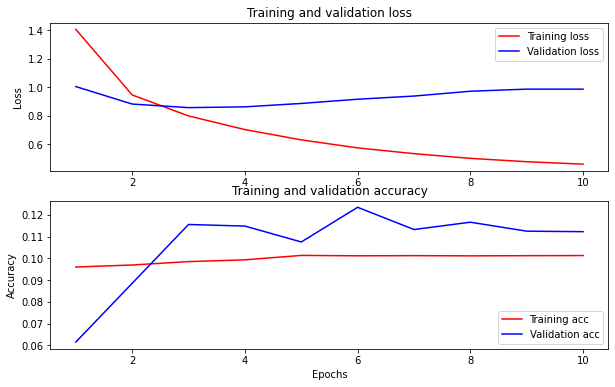

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
# dataset_name = 'imdb'
# saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

# classifier_model.save(saved_model_path, include_optimizer=False)
classifier_model.save('model/bertmodel.pt')

In [ ]:
!zip -r model.zip model/


  adding: model/ (stored 0%)
  adding: model/bertmodel.pt/ (stored 0%)
  adding: model/bertmodel.pt/variables/ (stored 0%)
  adding: model/bertmodel.pt/variables/variables.data-00000-of-00001 (deflated 12%)
  adding: model/bertmodel.pt/variables/variables.index (deflated 79%)
  adding: model/bertmodel.pt/keras_metadata.pb (deflated 83%)
  adding: model/bertmodel.pt/saved_model.pb (deflated 92%)
  adding: model/bertmodel.pt/assets/ (stored 0%)
  adding: model/bertmodel.pt/assets/vocab.txt (deflated 53%)


In [ ]:
from google.colab import files
files.download("model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)